# Explicit Gradient Descent for Optical Plasma Spectroscopy

## Question: What are the primary species present in this plasma measurement?
We know the likely candidates which would be present in the sample, but we don't have a way to quantify the sources of light which are emitting the specturm as a whole.
#### What are we looking at?
The spectra that we might measure includes light emissions due to electron collisions in a certain type of plasma which is excited through magnetic fields (RF inductively coupled). The light is generated by several versions of the same element, which exist in different electronic and molecular states, each version giving off a signature 'fingerprint' emission over wavelength space, $I(\lambda)$, which has been measured and recorded by scientists. For each possible energy/wavelength of light emitted, there is a relative weight associated with the intensity we can expect to measure at that wavelength. By combining all expected intensities, one can construct an ideal spectrum emitted by any one species of molecule/atom/ion.
#### Typical Oxygen Plasma Measurement & Motivation
The plasma is a deeply complicated system, dependent on a huge number of controlled and covariate factors. Things like the power which is used to generate the plasma and the gas pressure of the inlet can have a huge impact on the characteristics we are interested in. In order to quantify and correlate these effects with our target performance, we can use relative composition of the oxygen species to determine the state of the plasma.

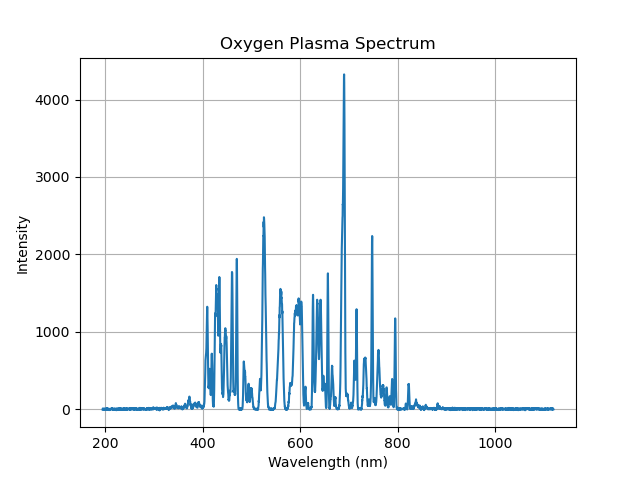

### What are we looking for?
The problem is to solve which combination of species will result in the observed measurement. Spectra for various elements can be found on the [NIST](https://www.nist.gov/pml/atomic-spectra-database) database. For this experiment, we used 5 distinct oxygen allotropes.
1. Oxygen molecule, O2
2. Oxygen molecule ion, O2+
3. Oxygen atom, O I
4. Oxygen ion (singly ionized), O II
5. Oxygen ion (doubly ionized), O III

### From database to real spectrum
How do we translate this raw data into something that we can match to our measured spectrum? First, see how this data looks plotted purely by the 'relative intensity' and the point-like wavelengths.

<img src="point_res.png">

This isn't very realistic for a couple reasons. 
- The physics of radiative emission guarantee some variation in the energy (i.e. wavelength) of the population emission statistics. We are measuring something on the order of $>10^{14}$ photons per second, each corresponding to one transition in a plasma species of interest.
- The measurement system isn't quite precise enough to measure the variance intrinsic to the plasma system. So, in this case, the limiting factor is the spectrometer, which we use to measure the incoming light. This is good news, because it's much easier to model the systematic variation in the spectrometer than the exact atomic physics which is happening in our system.
   

#### Solution: Upsample reference data to match an expected spectrometer performance.
<p> 
    Modeling the spectrometer's response to these incoming emissions will give a good approximation of how each species would appear to our measurement system. The resolution, defined by the manufacturer, is about 1 nm at FWHM. For simplicity, Gaussian estimates will be used for the signal 'falloff' as we move away from the true wavelength of the emission center (also known as kernel density estimation, KDE). If the variance of the gaussian kernel is set to the FWHM of the spectrometer (or more accurately, $\sigma^2\approx0.18$FWHM), we should have an idealized approximation of the real measurement system. For each species, for each pixel,</p>
    $$\textrm{Intensity}(pixel)=\Sigma_{lines} I_{line}exp\left(-\left(\frac{\lambda_{line}-\lambda_{pixel}}{2\sigma^2}\right)^2\right),$$
   <p> where we sum over all the lines in the database for that species. Through this method, we are endoding expected features into the previously un-physical test set. One result of this is that nearby emission line ($<1$ nm) will be adding measured intensity at overlapping pixels. This is one way the physical system is convoluted through the measurement and analysis process. A modeled emission spectrum of a few species might look like this:
    </p>
    

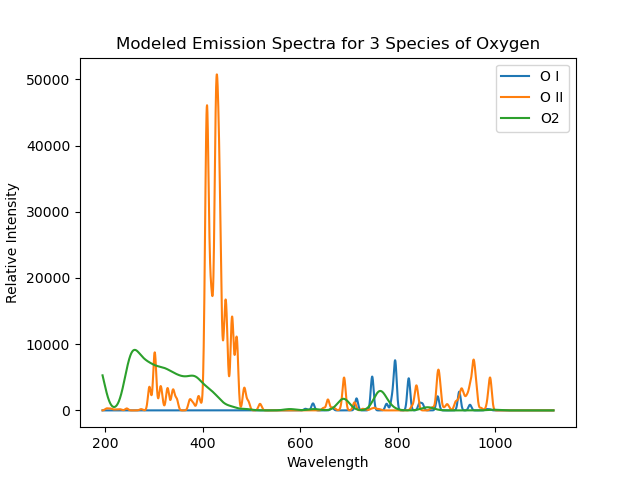

### Constructing the whole from the components
<p>
    We want to put together our individual species into a combination which looks the most similar to the measured spectrum. If we think of the problem as a linear combination of the components adding to some resultant sum, we can see that the problem turns into a linear regression problem in a *species*-dimensional space. Fortunately, this type of problem can be easily implemented via gradient descent, which leads to the next question: how do we quantify the accuracy of our guess as to what the constituent species are in our plasma? </p><p>
    We need a measure of how far off our guess is from the real spectrum, which can be modeled as a classic residual sum of squares commonly used for all types of model fitting. This implementation will subtract the *summed* weighted spectra for each species from the target spectrum to find residuals which will be squared, and then integrate over all wavelengths to find the total RSS for the given weights of the model. 
    </p>
    $$cost(\overrightarrow{\theta})=L(\overrightarrow{\theta})=\int_{\lambda}\left[target(\lambda) - \left(\sum_{species}\theta_{species}\odot I_{species}(\lambda)\right) \right]^2 d\lambda$$
Introducing a normalization factor to the cost function to keep things training at the same rate between runs:
$$A_{norm}=\left[\int_\lambda target(\lambda)d\lambda\right]^{-1},\: L_{norm}(\overrightarrow{\theta})=A_{norm}*L(\overrightarrow{\theta})$$
This will help guard against divergence in the algorithm.

## Gradient Descent for Cost Minimization
<p>
    Now that we have a measure of the accuracy of our guess, we need to learn from our mistakes and tweak the weights of each species to step towards the right composition. Luckily, our simple RSS cost function can be easily turned into a gradient function through differentiation with respect to the weights. An example for how this can be done with one component species, $i$, is shown below.
    </p>
    $$\nabla L(\theta_i)=\frac{\partial}{\partial \theta_i}\int_{\lambda}\left[target(\lambda) - \left(\sum_{species}\theta_{species}\odot I_{species}(\lambda)\right) \right]^2 d\lambda$$
    $$=-2\int_{\lambda}\left[target(\lambda) - \left(\sum_{species}\theta_{species}\odot I_{species}(\lambda)\right) \right]*[I_i(\lambda)] d\lambda$$
<p>
    Through the powers of vector multiplication and the chain rule, the gradient is achieved. Yes, there is still an integral because the cost exists as a function over all wavelength-space, but the weight gradient is allowed to pass through because $\lambda$ and $\theta$ are independent variables. Notice how the first bracketed term is the same due to the chain rule (minus a square), but the second term is reduced to only the intensity function for that particular species. What is happening here is the total difference between guess and reality is being multiplied by the base, unweighted spectrum of a species to gauge how much impact a small change in weights will have. It's not the most obvious because the terms are convolved to get the cost function, but this is what is telling the descent algorithm how far to tweak the components.
    </p>
    

# Implementation & Testing
<p>
    Now that we have the necessary tools, we can ask our computer to try to use them in finding an answer to our question. These algorithms were implemented using Python 3, with packages Pandas, Numpy, Scipy, and matplotlib. All of the preprocessing and gradient descent modules were written by me on this framework.
    </p>

In [1]:
from SpectrumFitting import WeightFinding

In [2]:
from GradVisualization import GradVis as gv
# Comprehensive modules for fitting and plotting fits,
# built on top of other data processing modules

### Test on some data
<p>
    I encourage you to continue through this notebook before going to the source code, as there are some spoilers for interesting insights there!
    </p>

In [3]:
wf = WeightFinding() # Spectrum fitting tool
vis= gv()            # Plotting tool

In [4]:
results1 = wf.gradientDescent(learning_rate=.00002,iterations=5000) # Might take a few seconds. 

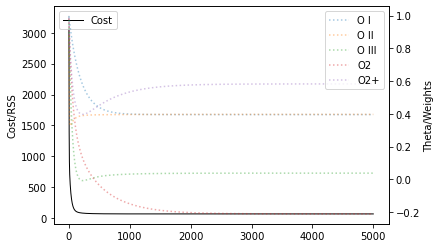

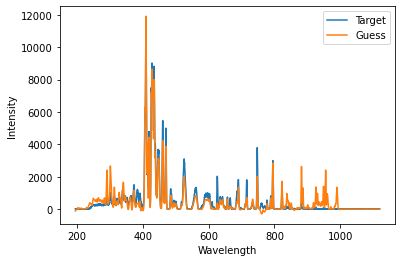

In [5]:
et=vis.cost_plot(results1)
vis.target_vs_guess(wf.target,wf.refLines.makeWeightedSpectrum(wf.base, results1[0]))

In [6]:
result_list=[]
for timestamp in list(wf.data.df.index):
    wf.target = wf.data.getSpectrum(timestamp)
    result_list.append(wf.gradientDescent(learning_rate=2e-5,iterations=5000))

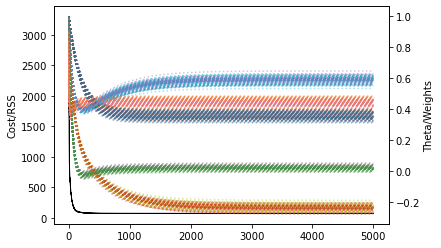

In [7]:
vis.cost_summary(result_list)
# Thetas show that convergence may take more iterations for different species. This could be improved by introducing
# learning rate factors by species to normalize training rate.

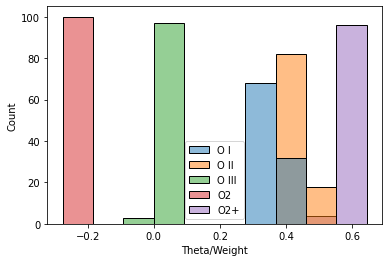

In [8]:
th_df=vis.theta_hist(result_list)
# Distribution of thetas after N iterations for all the spectra.

In [ ]:
ax=vis.guess_resid_plot(wf.target,wf.refLines.makeWeightedSpectrum(wf.base, result_list[-1][0]))
# Residuals for one of the spectra and the model fit to it.

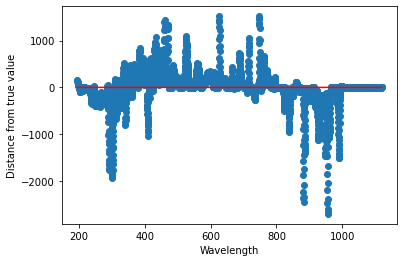

In [9]:
vis.plot_finalCosts(result_list)

### Addressing Residuals
Normally we would hope to see the distribution of residuals randomly distributed around the zero-point line, but in this case, there is obvious structure. Having some knowledge for the measurement system can be informative of why we might be getting these systematics. If we think over what is being measured, we can realize that there may be some light absorption between the plasma and the spectrometer. The limiting factor in this case is the borosilicate window between the ultra-high vacuum area and the spectrometer lens. The window has a certain transmission allowance which mostly allows light through in the visible range (380-700 nm) and absorbs more light outside of this range. The transimission band might look something like this:
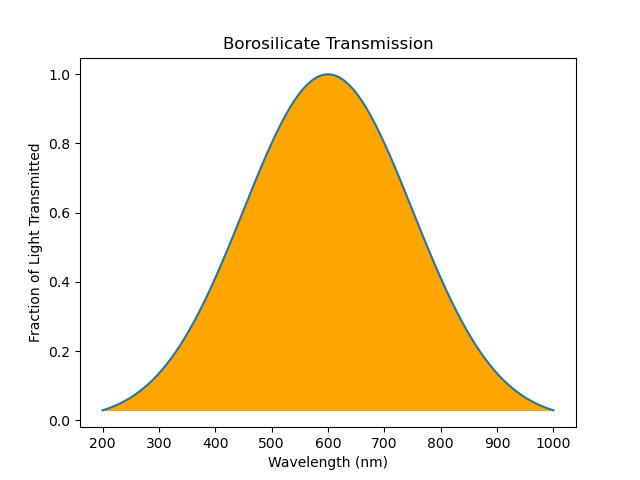
To address this, we can attenuate the reference base spectra before the gradient descent to try to better match this physical process.

In [10]:
wf2 = WeightFinding()
wf2.attenuation=True
wf2.center=600
wf2.std=175

In [11]:
result_list2=[]
for timestamp in list(wf2.data.df.index):
    wf2.target = wf2.data.getSpectrum(timestamp)
    result_list2.append(wf2.gradientDescent(learning_rate=5e-5,iterations=5000))

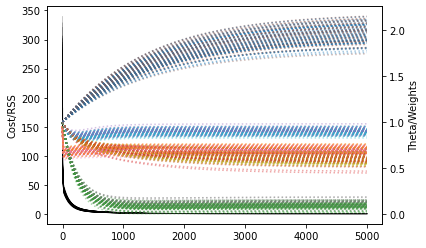

In [12]:
vis.cost_summary(result_list2)

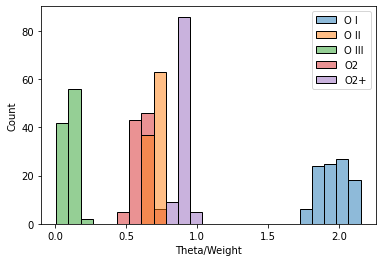

In [13]:
th2=vis.theta_hist(result_list2)
# Introducing an attenuation to the spectrum drastically changed the component species weights!

Not only did we change the weight values, we changed the ordering of species by weights, which is an entirely different regime of the plasma conditions.

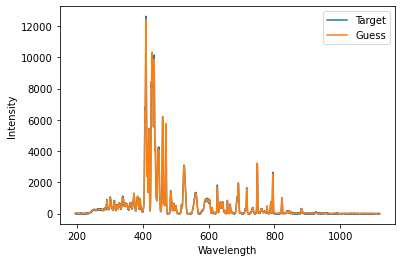

In [14]:
vis.target_vs_guess(wf.target,wf.refLines.makeWeightedSpectrum(wf2.base, result_list2[-1][0]))
# Very close match

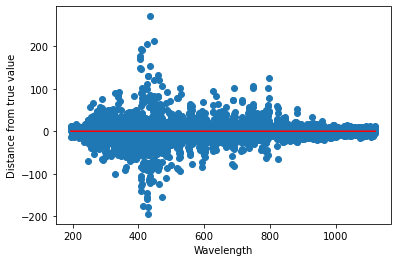

In [15]:
ax=vis.guess_resid_plot(wf2.target,wf2.refLines.makeWeightedSpectrum(wf2.base, result_list2[-1][0]))
# Residuals look mostly normal

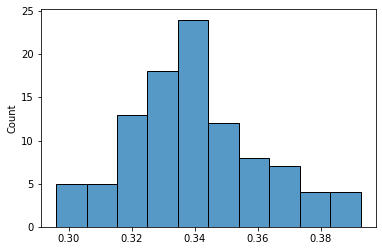

In [19]:
fcplot=vis.plot_finalCosts(result_list2)

This is suspiciously low for an experiment of this nature and the absolute intensities of the spectra ($>$10000 counts).
> ⚠️ **Fake Data Detected!!!**
#### Yes, all the data shown here is toy data.
Because the actual spectral data is somewhat sensitive IP, I am unable to share it via this platform, or speak to the real results in great detail. I did try to recreate as many of the real characteristics as possible in this data by adding pixel noise, variation in the species weights, etc. However, there were interesting parallels between this novel characterization technique and existing optimization procedures which have been long running solutions to the types of processes that this approach is pursuing. However, because all of the techniques I've shown are known techniques in x-ray surface analysis, or [XPS](https://doi.org/10.1116/6.0000377). The marginal gain from using this technique over individual line measurements for known emissions isn't great, and I can't recommend it over a more established technique like [actinometry](https://doi.org/10.1088/1361-6595/ab7cbe). What ultimately causes this technique to fall short is the complex dependence of each emission energy/wavelength on conditions intrinsic to the plasma which can completely change the intensities emitted by each species.